# 9-1 문제 설정

먼저 관심있는 데이터를 수집했고, 그 데이터에 대해 뭔가 궁금하게 생각하는 의문이 있을 것이다.

예를 들어 '따릉이' 데이터에 대해 (1) 대여가 증가하는 추세인지? (2) 계절별로 차이가 있는지? 의문 또는 문제를 가질 수 있겠다.

이러한 의문은 증명가능하도록 만들어져야 분석을 통해 답할 수 있다.

문제는 2개만 만들자.

# 9-2 문제의 답

데이터를 분석을 하고 앞서 앞서 제기된 문제에 대해 답을 하자.

대여가 증가하는 추세이면 시간별로 대여건수가 늘어나는지 분석을 하여 (1) 맞다 또는 (2) 맞지 않다라고 결정할 수 있어야 한다.

시간별 대여건수를 그래프로 시각화하여 보여줄 수도 있다.

정량데이터이면 describe, groupBy, 통계검증 (anova), 상관관계 등 강의에서 배운 명령어를 활용하자.

정성데이터는 단어빈도를 계산해서, 어떤 단어가 많이 사용되었는지 분석할 수 있다.

---

In [3]:
import pyspark
import os

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [4]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
def classifySeason(m):
    s=""
    m = int(m)
    if 3<=m<=5:
        s="봄"
    elif 6<=m<=8:
        s="여름"
    elif 9<=m<=10:
        s="가을"
    elif 1<=m<=2 or 11<=m<=12:
        s="겨울"
    else:
        s="no"
    return s
season_udf = udf(classifySeason, StringType())

In [5]:
jfile = os.path.join('data','MonthlyAverageAirQuality.json')
_air = spark.read.json(jfile)
_air = _air.withColumn('year', _air.MSRDT_MT.substr(1,4))\
            .withColumn('month', _air.MSRDT_MT.substr(5,2))
_air = _air.withColumn('season', season_udf(_air.month))\
            .select('year', 'month', 'season', 'MSRSTE_NM', 'PM10')\
            .withColumnRenamed('PM10', '미세먼지 농도')\
            .filter(_air['MSRSTE_NM']=='강남구')\
            .drop('MSRSTE_NM')
air = _air.toPandas()

## (1) 미세먼지 농도의 수준이 심각해지는 추세인가?

In [6]:
air_year = _air.groupBy('year').agg({'미세먼지 농도': "avg"}).orderBy('year').toPandas()
air_year.set_index('year', drop=True, append=False, inplace=True)
air_year.rename(columns={'avg(미세먼지 농도)': '평균 미세먼지 농도'}, inplace=True)
air_year.transpose()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
평균 미세먼지 농도,52.5,50.416667,43.333333,46.583333,46.416667,46.0,51.0,44.583333,34.583333,40.166667,32.083333


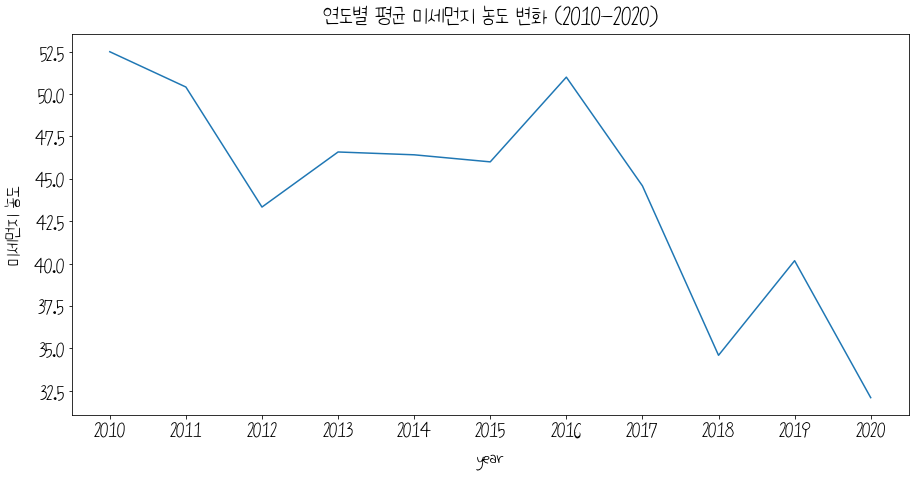

In [7]:
import matplotlib.pyplot as plt
plt.rc('font', family='Nanum BaReunHiPi', size=20)
plt.figure(figsize=(15,7))
plt.title('연도별 평균 미세먼지 농도 변화 (2010-2020)')
plt.xlabel('year')
plt.ylabel('미세먼지 농도')
plt.plot(air_year)

### 답: 심각해지는 추세가 아니다. 과거에 비하면 평균 미세먼지 농도가 낮아지고 있는 편이다.

---

## (2) 계절별로 차이가 있는가?

In [8]:
air_season = _air.groupBy('year').pivot('season').agg({'미세먼지 농도': "avg"}).orderBy('year').toPandas()
air_season.set_index('year', drop=True, append=False, inplace=True)
air_season.transpose()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
가을,36.000000,40.500000,34.500000,29.500000,30.500000,36.000000,41.500000,30.000000,20.000000,27.500000,24.000000
겨울,65.500000,53.500000,50.250000,53.250000,50.750000,53.500000,52.500000,48.000000,45.250000,50.500000,37.500000
봄,59.666667,68.666667,51.000000,57.000000,62.333333,56.333333,66.666667,61.000000,40.666667,47.666667,36.666667
여름,39.000000,34.666667,32.333333,38.666667,35.333333,32.333333,39.666667,33.333333,24.000000,27.333333,25.666667


<AxesSubplot:title={'center':'계절별 평균 미세먼지 농도 변화 (2010-2020)'}, xlabel='year', ylabel='미세먼지 농도'>

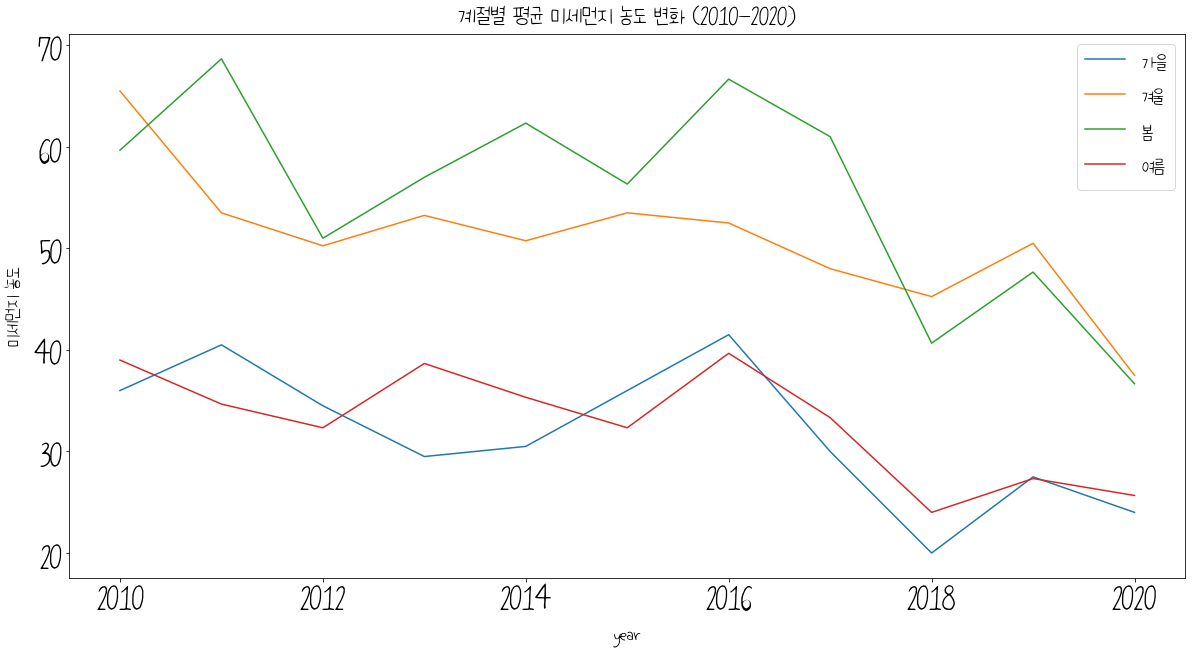

In [9]:
air_season.plot(fontsize=30, title='계절별 평균 미세먼지 농도 변화 (2010-2020)', figsize=(20,10),
               xlabel='year', ylabel='미세먼지 농도')

### 답: 계절별로 차이가 나타난다. 가을과 여름에는 미세먼지 농도가 낮고, 겨울과 봄에는 높은 편이다.

---

In [10]:
spark.stop()